# iLykei Lecture Series

# Machine Learning

# Introduction to Deep Learning

# Tuning Nets with Keras

## Yuri Balasanov, Leonid Nazarov, &copy; iLykei 2017-2018


This notebook shows how to tune basic network parameters: number of epochs, dropout rate, learning rate, number of neurons in the layers, optimization algorithm.

Import all necessary modules.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import to_categorical, plot_model
from keras.optimizers import Adam,SGD,Adagrad
from keras.utils.vis_utils import model_to_dot
from keras.wrappers.scikit_learn import KerasClassifier
from IPython.display import SVG


Using TensorFlow backend.


# Data (Kaggle OTTO  Group challenge)

Tuning methods will be demonstrated on the train dataset from Kaggle [Otto Group Product Classification Challenge](https://www.kaggle.com/c/otto-group-product-classification-challenge).  
Read the data, remove 'id' column and shuffle rows since they are originally oredered by class. 

In [3]:
X = pd.read_csv("KaggleOtto_train.csv")
X.drop('id', axis=1, inplace=True)
print(X.shape)
np.random.seed(1)
# Shuffle data. It is originally oredered by class
X = X.reindex(np.random.permutation(X.index))

FileNotFoundError: [Errno 2] File KaggleOtto_train.csv does not exist: 'KaggleOtto_train.csv'

This is a multiclass classification problem. 

Keras loss function for this problem is `categorical_crossentropy` (multiclass logloss). 

There is important note in the manual:  <br>
when using the `categorical_crossentropy` loss, your targets should be in categorical format (e.g. if you have 10 classes, the target for each sample should be a 10-dimensional vector that is all-zeros except for 1 at the index corresponding to the class of the sample). 

In order to convert integer targets into categorical targets, you can use Keras utility `to_categorical`:

`from keras.utils import to_categorical`
`categorical_labels = to_categorical(int_labels, num_classes=None)`

The target variable initially is in string format:

In [11]:
X.target[:6]

34888    Class_8
33063    Class_1
18402    Class_5
48904    Class_9
8078     Class_3
24224    Class_6
Name: target, dtype: object

Convert strings to integers and then to categorical format

In [12]:
# Extract target
# Encode it to make it manageable by ML algo, convert to np.int32
y = X.target.values
encoder = LabelEncoder()
y = encoder.fit_transform(y).astype(np.int32)
num_classes = len(encoder.classes_)
# convert class vectors to binary class matrices
y = to_categorical(y, num_classes)

# Remove target from train
X.drop('target', axis=1, inplace=True)

y[:6,:]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]], dtype=float32)

It was noticed during competition that logarithmic transfrom improves performance of most of ML algrithms. Transform the data and convert them to numpy array.

In [13]:
num_features = X.shape[1]
# log transform to decrease large values affect
X = np.log(1+X.values)

# The baseline model

Start tunning sequential network with two hidden layers and dropout layers after each of them. 

The following function creates such network.

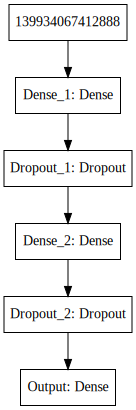

In [14]:
def getModel(dropout=0.1, neurons1=500, neurons2=250,
             learningRate=0.04):
    np.random.seed(1)
    model = Sequential()
    model.add(Dense(neurons1, activation='relu', input_dim=num_features,
                    name='Dense_1'))
    model.add(Dropout(dropout,name='Dropout_1'))
    model.add(Dense(neurons2, activation='relu',name='Dense_2'))
    model.add(Dropout(dropout,name='Dropout_2'))
    model.add(Dense(num_classes, activation='softmax',name='Output'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adagrad(lr=learningRate), metrics=['accuracy'])
    return model

model1 = getModel()

SVG(model_to_dot(model1).create(prog='dot', format='svg'))

The network was created by `getModel()` with default parameters. Method `Fit` has parameter  

`validation_split`: float (0. < x < 1): this is fraction of the data to use as hold-out validation data.  

Set `validation_split = 0.2` i.e. 20% of data will be used for validation. <br>
Fit the model and draw validation loss plot. <br>
Since we want to show validation loss behaviour after it reaches minimum, we do not use `EarlyStopping` callback.

In [15]:
net1 = model1.fit(X, y, epochs=12, batch_size=512, verbose=2,
                  validation_split=0.2)

Train on 44702 samples, validate on 11176 samples
Epoch 1/12
 - 3s - loss: 13.5327 - acc: 0.1494 - val_loss: 11.9084 - val_acc: 0.2585
Epoch 2/12
 - 2s - loss: 5.4701 - acc: 0.5236 - val_loss: 0.6752 - val_acc: 0.7434
Epoch 3/12
 - 2s - loss: 0.6053 - acc: 0.7688 - val_loss: 0.5779 - val_acc: 0.7747
Epoch 4/12
 - 2s - loss: 0.5439 - acc: 0.7880 - val_loss: 0.5569 - val_acc: 0.7854
Epoch 5/12
 - 2s - loss: 0.5098 - acc: 0.8003 - val_loss: 0.5380 - val_acc: 0.7867
Epoch 6/12
 - 2s - loss: 0.4818 - acc: 0.8112 - val_loss: 0.5313 - val_acc: 0.7912
Epoch 7/12
 - 2s - loss: 0.4602 - acc: 0.8180 - val_loss: 0.5159 - val_acc: 0.8010
Epoch 8/12
 - 2s - loss: 0.4408 - acc: 0.8251 - val_loss: 0.5254 - val_acc: 0.7983
Epoch 9/12
 - 2s - loss: 0.4219 - acc: 0.8316 - val_loss: 0.5347 - val_acc: 0.7967
Epoch 10/12
 - 2s - loss: 0.4059 - acc: 0.8380 - val_loss: 0.5220 - val_acc: 0.8040
Epoch 11/12
 - 2s - loss: 0.3914 - acc: 0.8442 - val_loss: 0.5103 - val_acc: 0.8059
Epoch 12/12
 - 2s - loss: 0.3752 

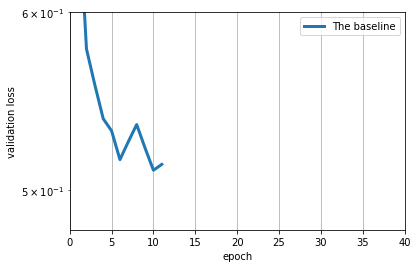

In [16]:
valid_loss1 = net1.history["val_loss"]
plt.plot(valid_loss1, linewidth=3, label="The baseline")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 40)
plt.ylim(0.48, 0.6)
plt.yscale("log")
plt.show()

Note that optimal performance is often achieved around `epoch = 7`.
For later epochs the model is overfitting, and performance is worse.

# Increase dropout

Add some drop out to prevent overfitting.

In [17]:
increasedDropout = 0.4
model2 = getModel(increasedDropout)
net2 = model2.fit(X, y, epochs=12, batch_size=512, verbose=2,validation_split=0.2)

Train on 44702 samples, validate on 11176 samples
Epoch 1/12
 - 2s - loss: 1.1428 - acc: 0.6855 - val_loss: 0.6270 - val_acc: 0.7615
Epoch 2/12
 - 3s - loss: 0.6268 - acc: 0.7615 - val_loss: 0.5832 - val_acc: 0.7736
Epoch 3/12
 - 2s - loss: 0.5845 - acc: 0.7717 - val_loss: 0.5565 - val_acc: 0.7819
Epoch 4/12
 - 2s - loss: 0.5594 - acc: 0.7840 - val_loss: 0.5413 - val_acc: 0.7873
Epoch 5/12
 - 2s - loss: 0.5362 - acc: 0.7925 - val_loss: 0.5347 - val_acc: 0.7895
Epoch 6/12
 - 2s - loss: 0.5238 - acc: 0.7951 - val_loss: 0.5261 - val_acc: 0.7925
Epoch 7/12
 - 2s - loss: 0.5062 - acc: 0.8014 - val_loss: 0.5187 - val_acc: 0.7977
Epoch 8/12
 - 2s - loss: 0.4959 - acc: 0.8050 - val_loss: 0.5103 - val_acc: 0.7997
Epoch 9/12
 - 2s - loss: 0.4823 - acc: 0.8106 - val_loss: 0.5150 - val_acc: 0.7995
Epoch 10/12
 - 2s - loss: 0.4699 - acc: 0.8126 - val_loss: 0.5110 - val_acc: 0.8015
Epoch 11/12
 - 2s - loss: 0.4622 - acc: 0.8175 - val_loss: 0.5039 - val_acc: 0.8040
Epoch 12/12
 - 2s - loss: 0.4550 - 

Compare validation loss for `net1` and `net2`

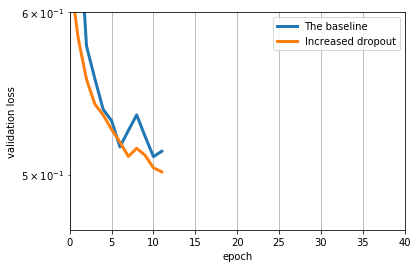

best validation loss 0.501605458062


In [18]:
valid_loss2 = net2.history["val_loss"]
plt.plot(valid_loss1, linewidth=3, label="The baseline")
plt.plot(valid_loss2, linewidth=3, label="Increased dropout")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 40)
plt.ylim(0.47, 0.6)
plt.yscale("log")
plt.show()
print('best validation loss', min(valid_loss2))

That is better. <br>
No more overfitting, and it feels like it is possible to increase number of epochs.

# Increase number of epochs

Increase number of epochs and check what loss can be reached.

In [19]:
model3 = getModel(increasedDropout)
net3 = model3.fit(X, y, epochs=25, batch_size=512, verbose=2, validation_split=0.2)

Train on 44702 samples, validate on 11176 samples
Epoch 1/25
 - 2s - loss: 1.5558 - acc: 0.6745 - val_loss: 0.6180 - val_acc: 0.7657
Epoch 2/25
 - 2s - loss: 0.6247 - acc: 0.7622 - val_loss: 0.5819 - val_acc: 0.7718
Epoch 3/25
 - 2s - loss: 0.5807 - acc: 0.7764 - val_loss: 0.5477 - val_acc: 0.7861
Epoch 4/25
 - 2s - loss: 0.5524 - acc: 0.7857 - val_loss: 0.5419 - val_acc: 0.7875
Epoch 5/25
 - 2s - loss: 0.5349 - acc: 0.7914 - val_loss: 0.5303 - val_acc: 0.7920
Epoch 6/25
 - 2s - loss: 0.5182 - acc: 0.7988 - val_loss: 0.5273 - val_acc: 0.7931
Epoch 7/25
 - 2s - loss: 0.5016 - acc: 0.8019 - val_loss: 0.5186 - val_acc: 0.8008
Epoch 8/25
 - 2s - loss: 0.4905 - acc: 0.8077 - val_loss: 0.5138 - val_acc: 0.7979
Epoch 9/25
 - 2s - loss: 0.4788 - acc: 0.8100 - val_loss: 0.5160 - val_acc: 0.8006
Epoch 10/25
 - 2s - loss: 0.4700 - acc: 0.8149 - val_loss: 0.5101 - val_acc: 0.8040
Epoch 11/25
 - 2s - loss: 0.4573 - acc: 0.8190 - val_loss: 0.5080 - val_acc: 0.8046
Epoch 12/25
 - 2s - loss: 0.4503 - 

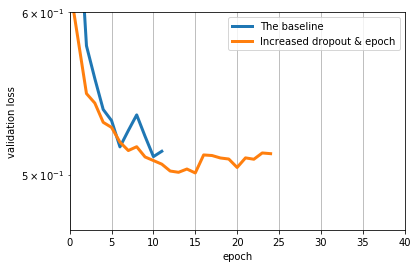

best validation loss 0.500978287707


In [20]:
valid_loss3 = np.array(net3.history["val_loss"])
plt.plot(valid_loss1, linewidth=3, label="The baseline")
plt.plot(valid_loss3, linewidth=3, label="Increased dropout & epoch")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 40)
plt.ylim(0.47, 0.6)
plt.yscale("log")
plt.show()
print('best validation loss', min(valid_loss3))

Try to improve performance further by adding neurons

# Increase number of neurons

Increase number of neurons in the first hidden layer.

In [21]:
increasedNeurons1 = 1000
model4 = getModel(increasedDropout, neurons1=increasedNeurons1)
net4 = model4.fit(X, y, epochs=25, batch_size=512, verbose=2, validation_split=0.2)

Train on 44702 samples, validate on 11176 samples
Epoch 1/25
 - 3s - loss: 5.8932 - acc: 0.4892 - val_loss: 0.6748 - val_acc: 0.7462
Epoch 2/25
 - 3s - loss: 0.6379 - acc: 0.7559 - val_loss: 0.5817 - val_acc: 0.7747
Epoch 3/25
 - 3s - loss: 0.5784 - acc: 0.7747 - val_loss: 0.5547 - val_acc: 0.7815
Epoch 4/25
 - 3s - loss: 0.5405 - acc: 0.7885 - val_loss: 0.5360 - val_acc: 0.7902
Epoch 5/25
 - 3s - loss: 0.5160 - acc: 0.7976 - val_loss: 0.5292 - val_acc: 0.7923
Epoch 6/25
 - 3s - loss: 0.4945 - acc: 0.8060 - val_loss: 0.5308 - val_acc: 0.7935
Epoch 7/25
 - 3s - loss: 0.4737 - acc: 0.8119 - val_loss: 0.5125 - val_acc: 0.8009
Epoch 8/25
 - 3s - loss: 0.4600 - acc: 0.8176 - val_loss: 0.5025 - val_acc: 0.8051
Epoch 9/25
 - 3s - loss: 0.4437 - acc: 0.8241 - val_loss: 0.5143 - val_acc: 0.8040
Epoch 10/25
 - 3s - loss: 0.4321 - acc: 0.8275 - val_loss: 0.5111 - val_acc: 0.8039
Epoch 11/25
 - 3s - loss: 0.4179 - acc: 0.8318 - val_loss: 0.5002 - val_acc: 0.8074
Epoch 12/25
 - 4s - loss: 0.4047 - 

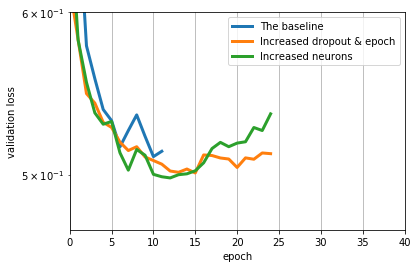

best validation loss 0.498193248989


In [22]:
valid_loss4 = net4.history["val_loss"]
plt.plot(valid_loss1, linewidth=3, label="The baseline")
plt.plot(valid_loss3, linewidth=3, label="Increased dropout & epoch")
plt.plot(valid_loss4, linewidth=3, label="Increased neurons")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 40)
plt.ylim(0.47, 0.6)
plt.yscale("log")
plt.show()
print('best validation loss', min(valid_loss4))

That is better, but we start overfitting around epoch 12. <br>

# Decrease learning rate

To prevent overfitting decrease the learning rate.

In [23]:
model5 = getModel(increasedDropout, neurons1=increasedNeurons1, learningRate=0.008)
net5 = model5.fit(X, y, epochs=30, batch_size=512, verbose=2, validation_split=0.2)

Train on 44702 samples, validate on 11176 samples
Epoch 1/30
 - 4s - loss: 0.7775 - acc: 0.7178 - val_loss: 0.6125 - val_acc: 0.7732
Epoch 2/30
 - 3s - loss: 0.6100 - acc: 0.7676 - val_loss: 0.5784 - val_acc: 0.7789
Epoch 3/30
 - 3s - loss: 0.5802 - acc: 0.7777 - val_loss: 0.5617 - val_acc: 0.7823
Epoch 4/30
 - 3s - loss: 0.5584 - acc: 0.7860 - val_loss: 0.5520 - val_acc: 0.7857
Epoch 5/30
 - 3s - loss: 0.5417 - acc: 0.7902 - val_loss: 0.5430 - val_acc: 0.7892
Epoch 6/30
 - 3s - loss: 0.5338 - acc: 0.7948 - val_loss: 0.5387 - val_acc: 0.7893
Epoch 7/30
 - 3s - loss: 0.5207 - acc: 0.7995 - val_loss: 0.5311 - val_acc: 0.7945
Epoch 8/30
 - 3s - loss: 0.5114 - acc: 0.8021 - val_loss: 0.5266 - val_acc: 0.7951
Epoch 9/30
 - 4s - loss: 0.5037 - acc: 0.8043 - val_loss: 0.5299 - val_acc: 0.7956
Epoch 10/30
 - 3s - loss: 0.4981 - acc: 0.8080 - val_loss: 0.5214 - val_acc: 0.7972
Epoch 11/30
 - 3s - loss: 0.4883 - acc: 0.8106 - val_loss: 0.5164 - val_acc: 0.7995
Epoch 12/30
 - 3s - loss: 0.4821 - 

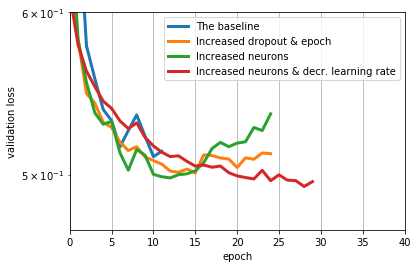

best validation loss 0.49342025969


In [24]:
valid_loss5 = net5.history["val_loss"]
plt.plot(valid_loss1, linewidth=3, label="The baseline")
plt.plot(valid_loss3, linewidth=3, label="Increased dropout & epoch")
plt.plot(valid_loss4, linewidth=3, label="Increased neurons")
plt.plot(valid_loss5, linewidth=3, label="Increased neurons & decr. learning rate")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 40)
plt.ylim(0.47, 0.6)
plt.yscale("log")
plt.show()
print('best validation loss', min(valid_loss5))

Low learning rate smoothed down validation loss curve and improved prediction quality. 
Now there is a good balance between number of neurons, dropout and learning rate. <br>
Note that other parameters could have been tuned too: number of layers, activation function etc.

<font color=blue>
    
**Assignment 1**  <br>
Tune sequentially droput rate, number of epochs and number of neurons of the following network:

![test_model6](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FLecture%207%20AdvML%2Ftest_model6.png)

Try to improve 'best validation loss' at least by 0.02 compare to starting point (dropout rate = 0, optimizer=Adagrad(lr=0.04). <br>
Do not change validation_split=0.2, optimizer and learning rate. 

![TunningPic1](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FLecture%207%20AdvML%2FTunningPic1.png)

In [ ]:
#Skipped code
# Assignment 1


# Tuning hyperparameters with grid search

Keras sequential models (single-input only) can be used in `scikit-learn` by wrapping them with the `KerasClassifier` or `KerasRegressor` class.

To use these wrappers define a function that creates and returns Keras sequential model, then pass this function to the `build_fn` argument when constructing `KerasClassifier` class. `build_fn` should construct, compile and return a Keras model, which will then be used to fit/predict. One of the following three values could be passed to build_fn:  

- A function
- An instance of a class that implements the call method
- None. This means you implement a class that inherits from either `KerasClassifier` or `KerasRegressor`. The call method of the present class will then be treated as the default `build_fn`.

E.g. we can create `KerasClassifier` instance with the above defined function `getModel` :

In [25]:
model = KerasClassifier(build_fn=getModel)

The constructor for the KerasClassifier class takes second argument   
`ssk_params`: model parameters & fitting parameters.  
We can pass there any legal model and fitting parameters. 

In [26]:
model = KerasClassifier(build_fn=getModel, epochs=20, batch_size=512, verbose=0)
model.get_params()

{'epochs': 20,
 'batch_size': 512,
 'verbose': 0,
 'build_fn': <function __main__.getModel(dropout=0.1, neurons1=500, neurons2=250, learningRate=0.04)>}

Since it is now scikit-learn Classifier, we can use Grid search - a model hyperparameter optimization technique provided in scikit-learn GridSearchCV class.  

When constructing this class we provide a dictionary of hyperparameters to evaluate in the `param_grid` argument.

By default, the grid search will only use one thread. <br>
By setting the `n_jobs` argument in the `GridSearchCV` constructor to -1, the process will use all cores on your machine. <br>
If `n_jobs` was set to a value higher than one, the data are copied for each point in the grid (but not `n_jobs` times). <br>
This is done for efficiency if individual jobs take very little time, but may raise errors if the dataset is large and there is not enough memory available. <br>
A workaround in this case is to set `pre_dispatch`. <br>
Then, the memory is copied only `pre_dispatch` number of times. <br>
A reasonable value for `pre_dispatch` is $2~\times~$n_jobs.

The `GridSearchCV` process will then construct and evaluate one model for each combination of parameters. <br>
Cross validation is used to evaluate each individual model (by default - 3-fold cross validation, this can be overridden by specifying the `cv` argument to the `GridSearchCV` constructor).  

We set "neg_log_loss" (negative logloss) as a scoring measure since  `GridSearchCV` is trying to maximize score.

In [29]:
# define the grid search parameters
param_grid = dict(dropout=[0.2, 0.3], neurons1=[300, 500])

grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    scoring="neg_log_loss", n_jobs=1)


In [30]:
grid_result = grid.fit(X, y)

We can extract results from `grid_result` attribute `cv_results_`. 

Recall that we were maximizing negative logloss. So, we output `-mean`  as logloss mean.

In [31]:
# summarize results
print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))


Best: 0.519940 using {'dropout': 0.3, 'neurons1': 300}
7.355310 (9.619374) with: {'dropout': 0.2, 'neurons1': 300}
0.554405 (0.012002) with: {'dropout': 0.2, 'neurons1': 500}
0.519940 (0.007963) with: {'dropout': 0.3, 'neurons1': 300}
8.814392 (11.727685) with: {'dropout': 0.3, 'neurons1': 500}


# Selecting Optimization Algorithm

Grid search may be applied not only to numerical parameters. 

We can find the best optimizer using it.

In [32]:
def getModel1(dropout=0.1, neurons1=500, neurons2=250,optimizer="Adagrad"):
    np.random.seed(1)
    model = Sequential()
    model.add(Dense(neurons1, activation='relu', input_dim=num_features))
    model.add(Dropout(dropout))
    model.add(Dense(neurons2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model


optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# create model
model = KerasClassifier(build_fn=getModel1, dropout=0.3, neurons1=300,
                        epochs=20, batch_size=512, verbose=0)
# define the grid search parameters

grid = GridSearchCV(estimator=model, param_grid=dict(optimizer=optimizer),
                    scoring="neg_log_loss",n_jobs=1)


In [33]:
grid_result = grid.fit(X, y)
# summarize results
print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

Best: 0.511470 using {'optimizer': 'Adam'}
0.746026 (0.002895) with: {'optimizer': 'SGD'}
0.516018 (0.002455) with: {'optimizer': 'RMSprop'}
0.522170 (0.002526) with: {'optimizer': 'Adagrad'}
0.519922 (0.001383) with: {'optimizer': 'Adadelta'}
0.511470 (0.002982) with: {'optimizer': 'Adam'}
0.518164 (0.001022) with: {'optimizer': 'Adamax'}
0.522406 (0.002461) with: {'optimizer': 'Nadam'}
